# INFS3208 Cloud Computing Project

## Amazon Data Analysis using various models

In this cloud computing project, we are going to do some data analysis including Sentiment Analysis,Recommendation Engine and Feature Predictions using four datasets about Amazon. Multiple tasks and models would be used to train the data including Classification, Clustering, Regression and  Collaborative Filtering models.

# 1.Sentiment analysis of Amazon reviews (Classification)

## 1.1 Data Preparation

### 1.1.1 Load file amazon_reviews.csv from HDFS

In [1]:
reviews_HDFS = "hdfs://namenode:9000/amazon_reviews.csv"
reviews_local = "amazon_reviews.csv"

In [2]:
import re
import time
import string
import numpy as np
import warnings
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType

# Initialize a Sparksession 
spark_classification = SparkSession.builder.appName("Classification").config("spark.port.maxRetries", "50").getOrCreate()

# Read reviews CSV file from HDFS 
reviews_df = spark_classification.read.option("multiLine", "true").option("header", "true").csv(reviews_local)

# Select the 'text' column and convert the 'text' column to RDDs
reviews_text_df = reviews_df.select("text")
reviews_text_rdd = reviews_text_df.rdd.map(lambda row: row['text'])

# Select the 'score' column and convert the 'score' column to RDDs
reviews_score_df = reviews_df.select("score")
reviews_score_rdd = reviews_score_df.rdd.map(lambda row: row['score'])

- print first five texts and first ten scores. Show the basic information about score.

In [3]:
for text in reviews_text_rdd.take(5):
    print("\n",text)


 I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

 "Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."

 "This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' ""The Lion

 If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (

In [4]:
for score in reviews_score_rdd.take(10):
    print("score:", score)

score: 5
score: 1
score: 4
score: 2
score: 5
score: 4
score: 5
score: 5
score: 5
score: 5


### 1.1.2 Cleansing data and avoid noise

In [5]:
def clean_data(text):
    if isinstance(text, str):
        # Remove any HTML tags, symbols, and extra characters
        text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        text = re.sub(r'\<.*?\>', ' ', text) 
        text = re.sub(r'&amp;', '', text)
        text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
        text = re.sub(r'<br\s*/?>', ' ', text)
        text = re.sub(r'\s+', ' ', text) 
        text = text.strip() 
        
        if text:
            return text
    return None 

# Apply the clean_data function to reviews_text_rdd 
reviews_text_rdd = reviews_text_rdd.map(clean_data).filter(lambda x: x is not None)

In [6]:
def clean_score(score):
    try:
        score = float(score)
        if score > 5 or score < 1:
            return 3
        else:
            return int(score) 
    except ValueError:
        return 3

# Apply the clean_score function to reviews_score_rdd 
reviews_score_rdd = reviews_score_rdd.map(clean_score)

In [7]:
# Add index
indexed_text_rdd = reviews_text_rdd.zipWithIndex()
indexed_score_rdd = reviews_score_rdd.zipWithIndex()

text_index = set(indexed_text_rdd.map(lambda x: x[1]).collect())
score_index = set(indexed_score_rdd.map(lambda x: x[1]).collect())

# Check which RDD has more or fewer elements
text_miss = score_index - text_index
score_miss = text_index - score_index

# Missing index information
if text_miss:
    print(f"Missing text for the following indices: {text_miss}")
if score_miss:
    print(f"Missing score for the following indices: {score_miss}")

# Filter out the missing indices so that both RDDs match in count
reviews_text_rdd = indexed_text_rdd.filter(lambda x: x[1] not in score_miss).map(lambda x: x[0])
reviews_score_rdd = indexed_score_rdd.filter(lambda x: x[1] not in text_miss).map(lambda x: x[0])

print(f"Filtered Text count: {reviews_text_rdd.count()}, Filtered Score count: {reviews_score_rdd.count()}")

# Zip the two RDDs together and show first 100 pairs
pairwise_rdd = reviews_text_rdd.zip(reviews_score_rdd)
for text, score in pairwise_rdd.take(100):
    print(f"Review: {text}, Score: {score} \n")


Missing text for the following indices: {28419}
Filtered Text count: 28419, Filtered Score count: 28419
Review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality The product looks more like a stew than a processed meat and it smells better My Labrador is finicky and she appreciates this product better than most, Score: 5 

Review: Product arrived labeled as Jumbo Salted Peanuts the peanuts were actually small sized unsalted Not sure if this was an error or if the vendor intended to represent the product as Jumbo, Score: 1 

Review: This is a confection that has been around a few centuries It is a light pillowy citrus gelatin with nuts in this case Filberts And it is cut into tiny squares and then liberally coated with powdered sugar And it is a tiny mouthful of heaven Not too chewy and very flavorful I highly recommend this yummy treat If you are familiar with the story of C S Lewis' The Lion, Score: 4 

Review: If you are look

## 1.2 Exploratory Data Analysis

### 1.2.1 Basic information about score

- Visualization of score distribution.

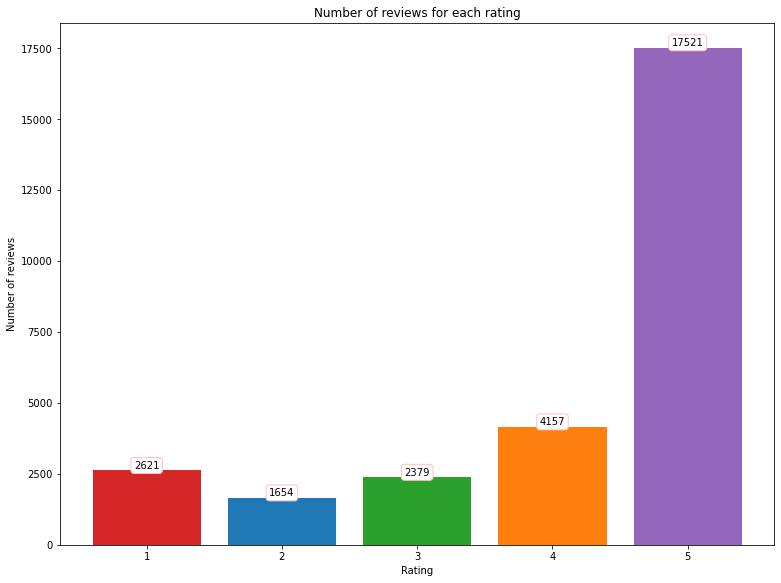

In [8]:
import matplotlib.pyplot as plt

# Group by 'score' to count the number of reviews per rating
reviews_score_df = reviews_score_df.filter((reviews_score_df["score"] >= 1) & (reviews_score_df["score"] <= 5))
rating_counts_df = reviews_score_df.groupBy("score").count()

rating_counts = rating_counts_df.collect()

# Extract ratings and counts into lists for plotting
ratings = [row['score'] for row in rating_counts]
counts = [row['count'] for row in rating_counts]

# Sort ratings and counts to ensure the bars are ordered by rating
ratings, counts = zip(*sorted(zip(ratings, counts)))

# Plot the bar chart with a linear y-axis 
fig, ax = plt.subplots(figsize=(12.8, 9.6)) 
bars = ax.bar(ratings, counts, color=['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple'])

# Set labels and title
ax.set_xlabel('Rating')
ax.set_ylabel('Number of reviews')
ax.set_title('Number of reviews for each rating')

# Add text boxes on top of each bar to show the exact count
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height,   
        f'{count}',                                  
        ha='center', va='bottom',                    
        bbox=dict(facecolor='white', edgecolor='pink', boxstyle='round,pad=0.3') 
    )

# Show the plot
plt.show()

From the bar plot, we can see the distribution is not balanced. Rating 5 has a significant higher number of reviews(17521) compared to the other classes while rating 2 has the lowest number(4157). Ratings 1 and 4 have similar numbers, but still much lower than Rating 5.Overall, the class distribution is not balanced, with a majority of the reviews being highly positive, indicating that users' reviews more positive.

## 1.3 Model Training

### 1.3.1 Feature extraction using BOW

- Split the clean dataset into separate train and test sets.

In [9]:
!pip install nltk
from pyspark.sql import Row
from pyspark.ml.feature import CountVectorizer, StopWordsRemover, Tokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from nltk.corpus import stopwords
import nltk

In [10]:
# Download stopwords from NLTK
nltk.download('stopwords')


# Combine reviews_text_rdd and reviews_score_rdd into a single RDD
combined_rdd = reviews_text_rdd.zip(reviews_score_rdd)

# Convert RDD to DataFrame (pairing text and score)
df = combined_rdd.map(lambda x: Row(Review=x[0], Rating=x[1])).toDF()

# Show the DataFrame for verification
df.show()

# Split the DataFrame into train (70%) and test (30%) sets
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

# Tokenize the review text 
tokenizer = Tokenizer(inputCol="Review", outputCol="words")
train_data = tokenizer.transform(train_df)
test_data = tokenizer.transform(test_df)

# Remove stopwords
stop_words = stopwords.words('english')
stop_words.extend(['amazon', 'one', 'product', 'tried', 'time', 'get'])

remover = StopWordsRemover(inputCol="words", outputCol="filtered_review", stopWords=stop_words)
train_data = remover.transform(train_data)
test_data = remover.transform(test_data)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


+--------------------+------+
|              Review|Rating|
+--------------------+------+
|I have bought sev...|     5|
|Product arrived l...|     1|
|This is a confect...|     4|
|If you are lookin...|     2|
|Great taffy at a ...|     5|
|I got a wild hair...|     4|
|This saltwater ta...|     5|
|This taffy is so ...|     5|
|Right now I'm mos...|     5|
|This is a very he...|     5|
|I don't know if i...|     5|
|One of my boys ne...|     5|
|My cats have been...|     1|
|good flavor these...|     4|
|The Strawberry Tw...|     5|
|My daughter loves...|     5|
|I love eating the...|     2|
|I am very satisfi...|     5|
|Twizzlers Strawbe...|     5|
|Candy was deliver...|     5|
+--------------------+------+
only showing top 20 rows



### 1.3.2 Using Logistic Regression model for training

- The first classification model using Logistic Regression:

In [11]:
# Vectorize the text using Spark's CountVectorizer
vectorizer = CountVectorizer(inputCol="filtered_review", outputCol="features", vocabSize=10000)
vectorizer_model = vectorizer.fit(train_data)

train_data_BOW = vectorizer_model.transform(train_data)
test_data_BOW = vectorizer_model.transform(test_data)

# Initialize logistic regression model 
lr = LogisticRegression(maxIter=200, labelCol="Rating")

# Train the logistic regression model using the BoW features
lr_model = lr.fit(train_data_BOW)

# Make predictions on the test data
lr_predictions = lr_model.transform(test_data_BOW)

# Select prediction and true label columns to evaluate
print("Results of predictions using Logistic Regression model:")
lr_predictions.select( "prediction", "Rating").show(30)

# Evaluate the model using accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Rating", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(lr_predictions)
print(f"Test Accuracy: {accuracy}")

Results of predictions using Logistic Regression model:
+----------+------+
|prediction|Rating|
+----------+------+
|       3.0|     3|
|       5.0|     5|
|       5.0|     5|
|       5.0|     5|
|       5.0|     5|
|       3.0|     3|
|       5.0|     5|
|       4.0|     3|
|       5.0|     5|
|       5.0|     3|
|       5.0|     5|
|       5.0|     1|
|       5.0|     5|
|       5.0|     5|
|       5.0|     3|
|       5.0|     5|
|       5.0|     5|
|       5.0|     3|
|       3.0|     3|
|       5.0|     5|
|       5.0|     3|
|       5.0|     1|
|       5.0|     3|
|       5.0|     1|
|       5.0|     5|
|       3.0|     3|
|       5.0|     1|
|       5.0|     5|
|       5.0|     5|
|       4.0|     4|
+----------+------+
only showing top 30 rows

Test Accuracy: 0.4787950383933845


### 1.3.3 Using Randon Forest model for training

- The second classification model using Random Forest(may take long time):

In [12]:
from pyspark.ml.feature import IDF
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# Apply TF-IDF Transformation to the training data 
idf = IDF(inputCol="features", outputCol="tfidf_features")
idf_model = idf.fit(train_data_BOW)

# Transform the training data with TF-IDF features
train_data_tfidf = idf_model.transform(train_data_BOW)

# Class balancing
class_1 = train_data_tfidf.filter(col("Rating") == 1).sample(withReplacement=True, fraction=12.275 / 1.868)
class_2 = train_data_tfidf.filter(col("Rating") == 2).sample(withReplacement=True, fraction=12.275 / 1.170)
class_3 = train_data_tfidf.filter(col("Rating") == 3).sample(withReplacement=True, fraction=12.275 / 1.733)
class_4 = train_data_tfidf.filter(col("Rating") == 4).sample(withReplacement=True, fraction=12.275 / 2.908)
class_5 = train_data_tfidf.filter(col("Rating") == 5)

# Combine the resampled classes into one balanced dataset
balanced_train_data = class_1.union(class_2).union(class_3).union(class_4).union(class_5)

# Initialize Random Forest model and training
rf = RandomForestClassifier(labelCol="Rating",featuresCol="tfidf_features",numTrees=200,maxDepth=15,minInstancesPerNode=10,maxBins=40)
rf_model = rf.fit(balanced_train_data)

# Make predictions on the test data 
test_data_tfidf = idf_model.transform(test_data_BOW)
rf_predictions = rf_model.transform(test_data_tfidf)

# Evaluation
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Rating", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(rf_predictions)
print("Results of predictions using RandomForest model:")
rf_predictions.select("prediction", "Rating").show(30)
print(f"Test Accuracy: {accuracy}")

Results of predictions using RandomForest model:
+----------+------+
|prediction|Rating|
+----------+------+
|       5.0|     3|
|       4.0|     5|
|       1.0|     5|
|       1.0|     5|
|       5.0|     5|
|       1.0|     3|
|       5.0|     5|
|       3.0|     3|
|       5.0|     5|
|       5.0|     3|
|       5.0|     5|
|       5.0|     1|
|       5.0|     5|
|       5.0|     5|
|       5.0|     3|
|       5.0|     5|
|       5.0|     5|
|       5.0|     3|
|       5.0|     3|
|       5.0|     5|
|       5.0|     3|
|       5.0|     1|
|       5.0|     3|
|       5.0|     1|
|       5.0|     5|
|       5.0|     3|
|       1.0|     1|
|       4.0|     5|
|       5.0|     5|
|       5.0|     4|
+----------+------+
only showing top 30 rows

Test Accuracy: 0.42847017129356174


## 1.4 Model  Evaluation

### 1.4.1 Model evaluation for Logistic Regression model

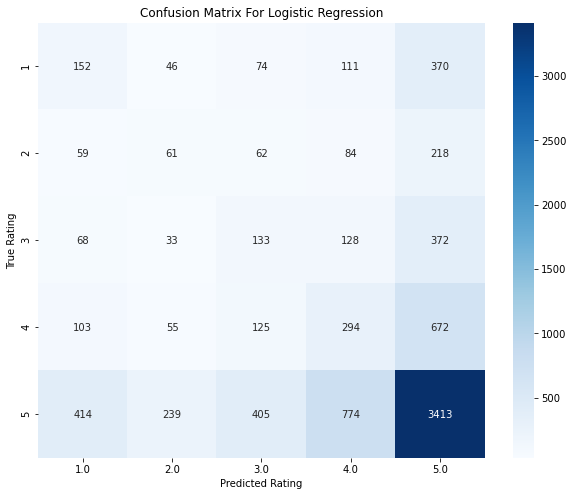

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F

confusion_matrix_df = lr_predictions.groupBy("Rating", "prediction").count().withColumnRenamed("count", "Frequency").orderBy("Rating", "prediction")

# Convert to pandas DataFrame for plotting
confusion_matrix_pandas = confusion_matrix_df.toPandas()
confusion_matrix = confusion_matrix_pandas.pivot(index="Rating", columns="prediction", values="Frequency")

# Plot confusion matrix using heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix For Logistic Regression')
plt.ylabel('True Rating')
plt.xlabel('Predicted Rating')
plt.show()

Generally speaking, the color bar above shows the frequency of occurrences for each pair of true and predicted labels.
Deeper colors (blue) represent higher values, meaning there are more instances where the model predicted that specific label correctly or incorrectly.

The diagonal elements represent the number of correct classifications where the predicted label matches the true label.
* Model correctly identified 152  "rating 1 reviews" as rating 1. 
* Model correctly identified 61  "rating 2 reviews" as rating 2.
* Model correctly identified 133  "rating 3 reviews" as rating 3.
* Model correctly identified 294  "rating 4 reviews" as rating 4.
* Model correctly identified 3413  "rating 5 reviews" as rating 5.

* <span style="color:blue">
There are 414 samples that were classified to have the rating of 1 (the lowest rating), but in reality, they had an actual rating of 5 (the highest rating). In contrast, there are 370 samples that were classified to have the rating of 5 (highest), but in reality, they only had an actual rating of 1 (lowest).</span>

### 1.4.2 Model evaluation for Random Forest model 

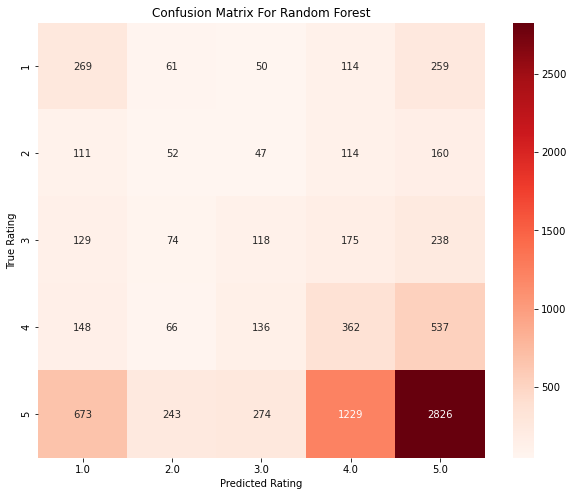

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F

confusion_matrix_df = rf_predictions.groupBy("Rating", "prediction").count().withColumnRenamed("count", "Frequency").orderBy("Rating", "prediction")

# Convert to pandas DataFrame for plotting
confusion_matrix_pandas = confusion_matrix_df.toPandas()
confusion_matrix = confusion_matrix_pandas.pivot(index="Rating", columns="prediction", values="Frequency")

# Plot confusion matrix using heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Reds")
plt.title('Confusion Matrix For Random Forest')
plt.ylabel('True Rating')
plt.xlabel('Predicted Rating')
plt.show()

spark_classification.stop()

The diagonal elements represent the number of correct classifications where the predicted label matches the true label.(nums may be different due to new training process,but approximate)
* Model correctly identified 269  "rating 1 reviews" as rating 1. 
* Model correctly identified 52  "rating 2 reviews" as rating 2.
* Model correctly identified 118  "rating 3 reviews" as rating 3.
* Model correctly identified 362  "rating 4 reviews" as rating 4.
* Model correctly identified 2826  "rating 5 reviews" as rating 5.

* <span style="color:red">
There are 625 samples that were classified to have the rating of 1 (the lowest rating), but in reality, they had an actual rating of 5 (the highest rating). In contrast, there are 286 samples that were classified to have the rating of 5 (highest), but in reality, they only had an actual rating of 1 (lowest).</span>

#  2.Movies Recommendation System (Clustering)

## 2.1 Data Preparation

### 2.1.1 Load file amazon_prime_movies.csv from HDFS

In [15]:
movies_HDFS = "hdfs://namenode:9000/amazon_prime_movies.csv"
movies_local = "amazon_prime_movies.csv"

In [16]:
# Initialize a Sparksession 
spark_clustering = SparkSession.builder.appName("Clustering").config("spark.port.maxRetries", "50").getOrCreate()

# Read CSV file from HDFS 
amazon_movies_data = spark_clustering.read.option("multiLine", "true").option("header", "true").csv(movies_local)
amazon_movies_data.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+--------------------------------+--------------------+-----------------+--------------------+-----------------+------------------+--------------------+--------------------+
|summary|             show_id|                type|               title|            director|                            cast|             country|       date_added|        release_year|           rating|          duration|           listed_in|         description|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------------------+--------------------+-----------------+--------------------+-----------------+------------------+--------------------+--------------------+
|  count|                9671|                9670|                9668|                7586|                            8435|                 725|              201|                9653|             931

In [17]:
# Rename columns
amazon_movies_data = amazon_movies_data.withColumnRenamed('date_added', 'date_added_platform')\
                         .withColumnRenamed('duration', 'duration_seconds')\
                         .withColumnRenamed('listed_in', 'gender_type')\
                         .withColumnRenamed('type', 'movie_or_tv_show')
amazon_movies_data.printSchema()

root
 |-- show_id: string (nullable = true)
 |-- movie_or_tv_show: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date_added_platform: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration_seconds: string (nullable = true)
 |-- gender_type: string (nullable = true)
 |-- description: string (nullable = true)



### 2.1.2 Cleansing data and avoid noise

- Handing the missing data:

In [18]:
# Filling NaN values
amazon_movies_data = amazon_movies_data.na.fill({
    'cast': 'uninformed cast',
    'director': 'uninformed director',
    'country': 'uninformed country'
})

In [19]:
# Delete movie if its attribute has null value
amazon_movies_data = amazon_movies_data.dropna(subset=[ 'duration_seconds',  'gender_type','movie_or_tv_show','release_year','rating'])

We can see the 'date_added_platform' column has very severe problem of missing values, so we delete this column, we also delete 'show_id' column because it is meaningless.

In [20]:
# Drop the 'date_added_platform' and 'show_id' columns
amazon_movies_data = amazon_movies_data.drop('date_added_platform', 'show_id', 'description')

In [21]:
from pyspark.sql.functions import col, sum as spark_sum

null_count_columns = []

for column in amazon_movies_data.columns:
    # Count the number of nulls in each column
    null_count = spark_sum(col(column).isNull().cast("int")).alias(column)
    null_count_columns.append(null_count)

amazon_movies_data.select(*null_count_columns).show()


+----------------+-----+--------+----+-------+------------+------+----------------+-----------+
|movie_or_tv_show|title|director|cast|country|release_year|rating|duration_seconds|gender_type|
+----------------+-----+--------+----+-------+------------+------+----------------+-----------+
|               0|    0|       0|   0|      0|           0|     0|               0|          0|
+----------------+-----+--------+----+-------+------------+------+----------------+-----------+



### 2.1.3 Encode categorical features

We need 'gender_type' feature in the dataset to do further clustering. However, the 'gender_type' column is so complex that we can split it into several columns. As data in the 'gender_type' are categorical instead of numeriacal, we also need to transform the data using encoding techniques such as one-hot encoding.

- Split and expend the 'gender_type' column

In [22]:
from pyspark.sql import functions as F

# Convert the 'gender_type' column to uppercase
amazon_movies_data = amazon_movies_data.withColumn('gender_type', F.upper(F.col('gender_type')))

# Split the 'gender_type' column and expand into separate columns
group_dummies = amazon_movies_data.select(F.split(F.col('gender_type'), ',').alias('gender_split'))

# Fill null values with '-'
group_dummies = group_dummies.withColumn('gender_split', F.expr("transform(gender_split, x -> coalesce(x, '-') )"))

# Explode the array into the exact number of split columns 
max_cols = 5
split_cols = [F.col("gender_split")[i].alias(f'category_{i}') for i in range(max_cols)]
group_dummies = group_dummies.select(*split_cols)
group_dummies = group_dummies.fillna('-')

# Show part of new dataframe
frame_segment = group_dummies.limit(50).subtract(group_dummies.limit(30))
frame_segment.show()

+-----------+-----------------+------------+----------+--------------------+
| category_0|       category_1|  category_2|category_3|          category_4|
+-----------+-----------------+------------+----------+--------------------+
|     ACTION| MILITARY AND WAR|     WESTERN|         -|                   -|
|       ARTS|    ENTERTAINMENT| AND CULTURE|    COMEDY| TALK SHOW AND VA...|
|     ACTION|          WESTERN|           -|         -|                   -|
|DOCUMENTARY|  SCIENCE FICTION|           -|         -|                   -|
|  ADVENTURE|        ANIMATION|        KIDS|         -|                   -|
|    FANTASY|  SCIENCE FICTION|    SUSPENSE|         -|                   -|
|   SUSPENSE|                -|           -|         -|                   -|
|     ACTION|                -|           -|         -|                   -|
|DOCUMENTARY|            LGBTQ|           -|         -|                   -|
|      DRAMA|          ROMANCE|    SUSPENSE|         -|                   -|

- Transform the categorical data into numerical data

In [23]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
import numpy as np
from pyspark.ml.linalg import DenseVector
from pyspark.sql.types import ArrayType, FloatType

# Create StringIndexer and OneHotEncoder for each column in group_dummies
stages = []
for col in group_dummies.columns:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
    encoder = OneHotEncoder(inputCol=col + "_index", outputCol=col + "_vec")
    stages += [indexer, encoder]

pipeline = Pipeline(stages=stages)
group_dummies_encoded = pipeline.fit(group_dummies).transform(group_dummies)

# Use VectorAssembler to combine all one-hot encoded columns into a single feature vector
assembler = VectorAssembler(inputCols=[col + "_vec" for col in group_dummies.columns], outputCol="features")
group_dummies_final = assembler.transform(group_dummies_encoded)

# Convert SparseVector to DenseVector
group_dummies_final = group_dummies_final.withColumn(
    "dense_features", F.udf(lambda x: x.toArray().tolist(), ArrayType(FloatType()))(group_dummies_final["features"])
)

# Collect the data and convert it to a NumPy array
X_genre_type = np.array(group_dummies_final.select("dense_features").rdd.map(lambda row: row["dense_features"]).collect(), dtype='uint8')

print(X_genre_type)

[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


# 2.2 Exploratory Data Analysis

### 2.2.1 Count of every categories after spliting

In [24]:
# Stack all the columns into a single column and filter out the '-' values
group_dummies_stacked = group_dummies.select(F.explode(F.array(*group_dummies.columns)).alias("category")).filter(F.col('category') != '-')

# Count occurrences of each unique element in descending order
category_counts = group_dummies_stacked.groupBy("category").count()
category_counts_sorted = category_counts.orderBy(F.col("count").desc())

# Display the result
category_counts_sorted.show(truncate=False)

+-----------------+-----+
|category         |count|
+-----------------+-----+
|DRAMA            |2141 |
|ACTION           |1604 |
| DRAMA           |1429 |
|COMEDY           |1425 |
| SUSPENSE        |1245 |
|DOCUMENTARY      |828  |
| SPECIAL INTEREST|709  |
| KIDS            |688  |
| COMEDY          |573  |
| ROMANCE         |536  |
|HORROR           |519  |
|ANIMATION        |487  |
| AND CULTURE     |430  |
| ENTERTAINMENT   |430  |
|ARTS             |404  |
|KIDS             |367  |
| SCIENCE FICTION |364  |
| HORROR          |328  |
| INTERNATIONAL   |308  |
|TV SHOWS         |260  |
+-----------------+-----+
only showing top 20 rows



### 2.2.2 Visualization of categorical distribution

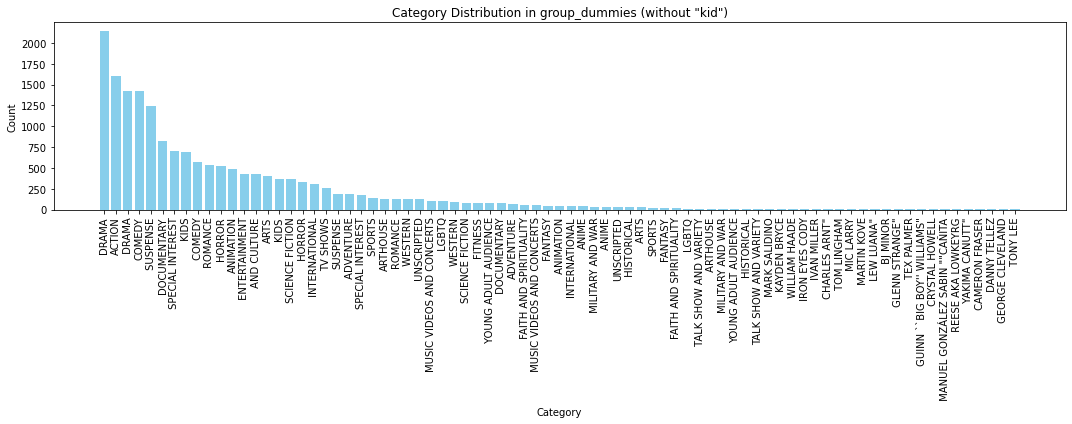

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
# Stack all the columns into a single column
group_dummies_stacked = group_dummies.select(F.explode(F.array(*group_dummies.columns)).alias("category"))

# Filter out the 'kid' element
group_dummies_stacked_filtered = group_dummies_stacked.filter(group_dummies_stacked.category != '-')

# Count occurrences of each unique element after removing 'kid'
category_counts_filtered = group_dummies_stacked_filtered.groupBy("category").count()

# Collect the counts into a Pandas DataFrame
category_counts_pd = category_counts_filtered.toPandas()

# Sort the counts for better visualization (optional)
category_counts_pd = category_counts_pd.sort_values(by="count", ascending=False)

# Plotting the distribution
plt.figure(figsize=(15, 6))
plt.bar(category_counts_pd['category'], category_counts_pd['count'], color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Distribution in group_dummies (without "kid")')
plt.xticks(rotation=90) 
plt.tight_layout()

# Show the plot
plt.show()

From the actual counting in descending order and the plot above, we can see DRAMA is the most frequent category, with a count of over 2000 occurrences. Other frequent categories include ACTION, DOCUMENTARY, SUSPENSE, and COMEDY, all having notable counts but significantly fewer than DRAMA. The frequencies gradually decrease for other categories like ROMANCE, HORROR, and ANIMATION.

## 2.3 Model Training

In this clutering task, we use K-means Clustering algorithm. Before clustering model traing, we have to decide the number of clusters which is very important. We use Elbow Method to find the optimal numbers of cluters.

### 2.3.1 Elbow Method to find optimal cluster number(may take long time)

- Elbow Method has three types of metrics for evaluation 
1. **silhouette** : mean ratio of intra-cluster and nearest-cluster distance 
2. **distortion** :  mean sum of squared distances to centers
3. **calinski_harabasz** : ratio of within to between cluster dispersion

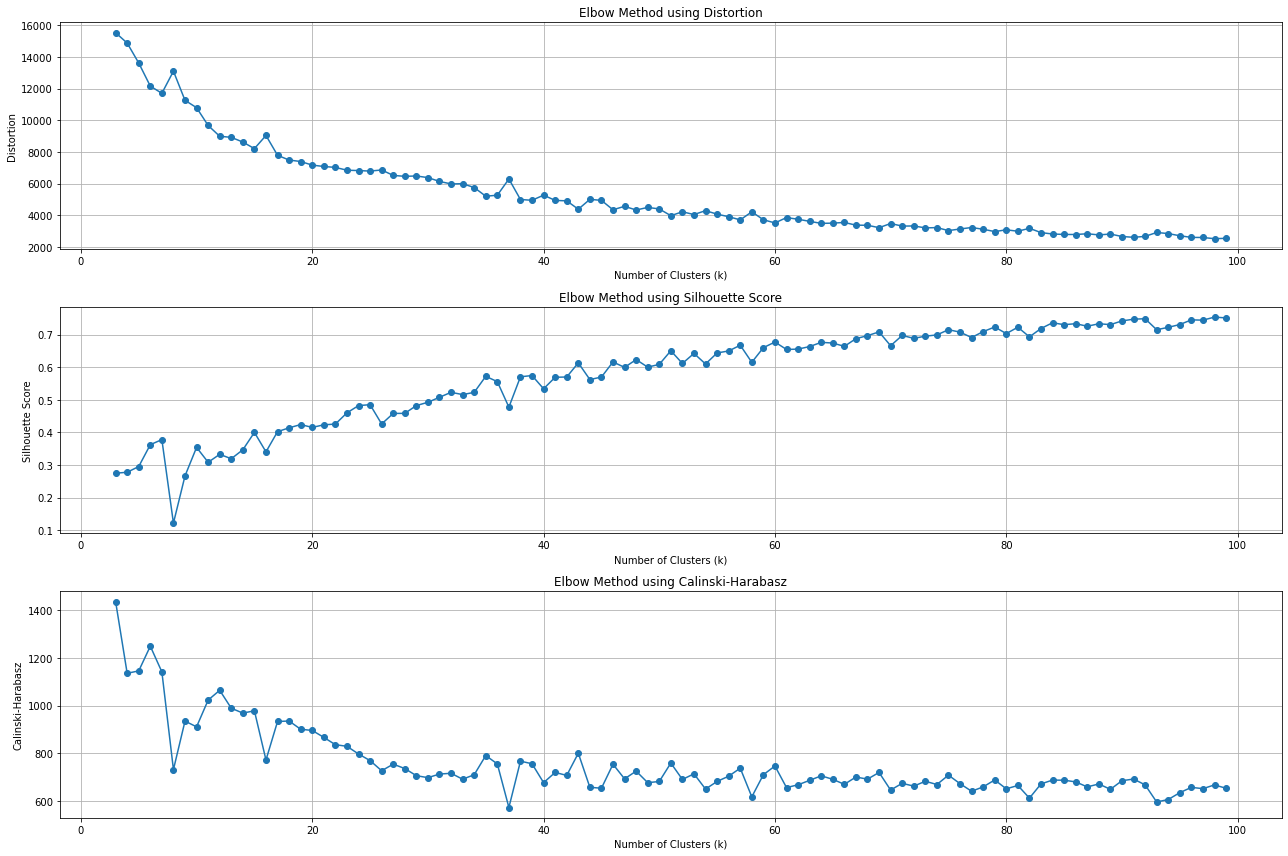

In [26]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn.metrics import calinski_harabasz_score

# Initialize lists to store scores
distortions, silhouette_scores, calinski_harabasz_scores = [], [], []
k_values = range(3, 100)

# Function to convert sparse vectors to dense for Calinski-Harabasz score
def to_dense_vector(sparse_vector):
    return np.array(sparse_vector.toArray())

# Loop over K values
for k in k_values:
    # Fit KMeans model
    kmeans = KMeans(k=k, seed=1, featuresCol="features", predictionCol="prediction").fit(group_dummies_final)
    predictions = kmeans.transform(group_dummies_final)

    # Store distortion
    distortions.append(kmeans.summary.trainingCost)

    # Silhouette score
    silhouette_scores.append(ClusteringEvaluator(predictionCol='prediction', featuresCol="features", metricName='silhouette').evaluate(predictions))

    # Calinski-Harabasz score
    feature_data = np.array(predictions.select("features").rdd.map(lambda row: to_dense_vector(row["features"])).collect())
    labels = np.array(predictions.select("prediction").rdd.map(lambda row: row["prediction"]).collect())
    calinski_harabasz_scores.append(calinski_harabasz_score(feature_data, labels))

# Plot Distortion, Silhouette, and Calinski-Harabasz score
metrics = {'Distortion': distortions, 'Silhouette Score': silhouette_scores, 'Calinski-Harabasz': calinski_harabasz_scores}
plt.figure(figsize=(18, 12))

for i, (title, values) in enumerate(metrics.items(), 1):
    plt.subplot(3, 1, i)
    plt.plot(k_values, values, marker='o')
    plt.title(f'Elbow Method using {title}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel(title)
    plt.grid(True)

plt.tight_layout()
plt.show()

For the first plot, Distortion measures the sum of squared distances between data points and their nearest cluster center. The lower the distortion, the better the fit. For the second plot,Silhouette score measures how well points are clustered together, ranging from -1 to 1. A score closer to 1 indicates well-separated and dense clusters, while a score near 0 indicates overlapping clusters. For the last plot,  Calinski-Harabasz score measures the ratio of between-cluster dispersion to within-cluster dispersion. A higher score means better-defined clusters.

By making a trade-off, we finally decide to choose the K values around 35.

### 2.3.2 K-means Clustering model training

In [27]:
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import monotonically_increasing_id

# K-means clustering
kmeans = KMeans(k=35, seed=0, featuresCol="features", predictionCol="prediction")
kmeans_model = kmeans.fit(group_dummies_final)

# make predictions
predictions = kmeans_model.transform(group_dummies_final)

# Add index to `amazon_movies_data` and `predictions`
amazon_movies_data = amazon_movies_data.withColumn("index", monotonically_increasing_id())
predictions = predictions.withColumn("index", monotonically_increasing_id())

# Join `amazon_movies_data` and `predictions` using index
data_amazon_cluster = amazon_movies_data.join(predictions.select("index", "prediction"), on="index", how="inner")

# Rename the prediction column to `clusters_genre`
data_amazon_cluster = data_amazon_cluster.withColumnRenamed("prediction", "clusters_genre")

data_amazon_cluster.select("title").show(10)

+--------------------+
|               title|
+--------------------+
|Take Care Good Night|
|            Zoombies|
|          Zoo Babies|
|Zoë Coombs Marr: ...|
|                 Zoe|
|          Zoboomafoo|
|Zo Zo Zombie: Min...|
|        Zis Boom Bah|
|        ZeroZeroZero|
|            Zandalee|
+--------------------+
only showing top 10 rows



- Now we can print some movies in the same genre. We have 35 clusters, for example we choose 17-19 groups to print.
- The 18th group are MILITARY movies, the 19th are HISTORICAL movies, while the 20th are ADVENTURE movies

In [28]:
from pyspark.sql.functions import col
filtered_data_18 = data_amazon_cluster.filter(col('clusters_genre') == 18).select('title', 'gender_type')
filtered_data_18.show(truncate=False)

+---------------------------+-----------------------+
|title                      |gender_type            |
+---------------------------+-----------------------+
|When the Lights Go On Again|DRAMA, MILITARY AND WAR|
|The Underdog (1943)        |DRAMA, MILITARY AND WAR|
|The North Star             |DRAMA, MILITARY AND WAR|
|The Admiral Was A Lady     |DRAMA, MILITARY AND WAR|
|Sundown                    |DRAMA, MILITARY AND WAR|
|Nurse Edith Cavell         |DRAMA, MILITARY AND WAR|
|A Farewell To Arms         |DRAMA, MILITARY AND WAR|
|Journey's End              |DRAMA, MILITARY AND WAR|
|Fugitive Pieces            |DRAMA, MILITARY AND WAR|
|Copperhead                 |DRAMA, MILITARY AND WAR|
+---------------------------+-----------------------+



In [29]:
filtered_data_19 = data_amazon_cluster.filter(col('clusters_genre') == 19).select('title', 'gender_type')
filtered_data_19.show(truncate=False)

+-----------------------------------+-----------------------------------+
|title                              |gender_type                        |
+-----------------------------------+-----------------------------------+
|The Mill                           |DRAMA, HISTORICAL                  |
|The Last Tycoon                    |DRAMA, HISTORICAL                  |
|The Last Post                      |DRAMA, HISTORICAL, MILITARY AND WAR|
|The Durrells in Corfu              |DRAMA, HISTORICAL, INTERNATIONAL   |
|Radioactive                        |DRAMA, HISTORICAL                  |
|Poldark                            |DRAMA, HISTORICAL                  |
|Padmaavat                          |DRAMA, HISTORICAL, INTERNATIONAL   |
|My Mother and Other Strangers      |DRAMA, HISTORICAL                  |
|Little Men                         |DRAMA, HISTORICAL                  |
|Little Dorrit                      |DRAMA, HISTORICAL                  |
|Home Fires                         |D

In [30]:
filtered_data_20 = data_amazon_cluster.filter(col('clusters_genre') == 20).select('title', 'gender_type')
filtered_data_20.show(truncate=False)

spark_clustering.stop()

+-------------------------------+----------------------------------+
|title                          |gender_type                       |
+-------------------------------+----------------------------------+
|Yu-Gi-Oh! ARC-V                |ACTION, ADVENTURE, ANIMATION      |
|What Comes Around              |ACTION, ADVENTURE, COMEDY         |
|UQ Holder!                     |ACTION, ADVENTURE, ANIME          |
|Trading Paint                  |ACTION, ADVENTURE                 |
|Tomorrow When The War Began    |ACTION, ADVENTURE                 |
|Ticker                         |ACTION, ADVENTURE, SUSPENSE       |
|The New Adventures of Tarzan   |ACTION, ADVENTURE                 |
|The King of Thieves            |ACTION, ADVENTURE, SUSPENSE       |
|The Corrupted                  |ACTION, ADVENTURE, DRAMA          |
|The 36th Chamber of Shaolin    |ACTION, ADVENTURE                 |
|Tarzan The Fearless            |ACTION, ADVENTURE                 |
|Superships                     |A

We have successfully trained and clustered movies into different groups based on their genre. If people want to watch movies of certain genre, we can give them recommendations based on our clusters.

# 3. Amazon Delivery Data Regression

## 3.1 Data Preparation

### 3.1.0 Import necessary libraries 

In [31]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, NumericType
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

### 3.1.1 Load file amazon_delivery.csv from HDFS

In [32]:
delivery_HDFS = "hdfs://namenode:9000/amazon_delivery.csv"
delivery_local = "amazon_delivery.csv"

In [33]:
# Initialize a Sparksession 
spark_regression = SparkSession.builder.appName("Regression").config("spark.port.maxRetries", "50").getOrCreate()

# Read CSV file from HDFS 
amazon_delivery_data = spark_regression.read.option("multiLine", "true").option("header", "true").csv(delivery_local)
amazon_delivery_data.show(5)

+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-----------+----------+-------+-----------+--------------+-------------+------------+
|
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-----------+----------+-------+-----------+--------------+-------------+------------+
|
|
|
|
|
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-----------+----------+-------+-----------+--------------+-------------+------------+
only showing top 5 rows



### 3.1.2  Cleansing data and avoid noise

- Check null values and remove them

In [34]:
null_count_columns = []

for column in amazon_delivery_data.columns:
    # Calculate the number of null values for each column and use alias to name the result as the original column name
    null_count = sum(col(column).isNull().cast("int")).alias(column)
    null_count_columns.append(null_count)

amazon_delivery_data.select(null_count_columns).show()

+--------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-----------+-------+-------+-------+----+-------------+---------+
|
+--------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-----------+-------+-------+-------+----+-------------+---------+
|       0|        0|          54|             0|              0|            0|             0|         0|         0|          0|      0|      0|      0|   0|            0|        0|
+--------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-----------+-------+-------+-------+----+-------------+---------+



In [35]:
amazon_delivery_data = amazon_delivery_data.dropna(subset = ['Agent_Rating'])
null_count_columns = []

for column in amazon_delivery_data.columns:
    null_count = sum(col(column).isNull().cast("int")).alias(column)
    null_count_columns.append(null_count)

amazon_delivery_data.select(null_count_columns).show()

+--------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-----------+-------+-------+-------+----+-------------+---------+
|
+--------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-----------+-------+-------+-------+----+-------------+---------+
|       0|        0|           0|             0|              0|            0|             0|         0|         0|          0|      0|      0|      0|   0|            0|        0|
+--------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-----------+-------+-------+-------+----+-------------+---------+



In [36]:
amazon_delivery_data = amazon_delivery_data.drop('Order_ID', 'Order_Date','Order_Time','Pickup_Time','Weather','Traffic','Vehicle','Area','Category')

## 3.2 Exploratory Data Analysis

### 3.2.1 Feature selection and casting

In [37]:
# Select numeric features
numeric_features = ['Agent_Age', 'Agent_Rating', 'Store_Latitude', 'Store_Longitude', 'Drop_latitude','Drop_Longitude', 'Delivery_Time']

- Ensure the data type to be numerical

In [38]:
from pyspark.sql.types import DoubleType

amazon_delivery_data = amazon_delivery_data.withColumn('Agent_Age', amazon_delivery_data['Agent_Age'].cast(DoubleType())) \
                       .withColumn('Agent_Rating', amazon_delivery_data['Agent_Rating'].cast(DoubleType())) \
                       .withColumn('Store_Latitude', amazon_delivery_data['Store_Latitude'].cast(DoubleType())) \
                       .withColumn('Store_Longitude', amazon_delivery_data['Store_Longitude'].cast(DoubleType())) \
                       .withColumn('Drop_latitude', amazon_delivery_data['Drop_latitude'].cast(DoubleType())) \
                       .withColumn('Drop_Longitude', amazon_delivery_data['Drop_Longitude'].cast(DoubleType())) \
                       .withColumn('Delivery_Time', amazon_delivery_data['Delivery_Time'].cast(DoubleType()))


### 3.2.2 Visualization of correlation

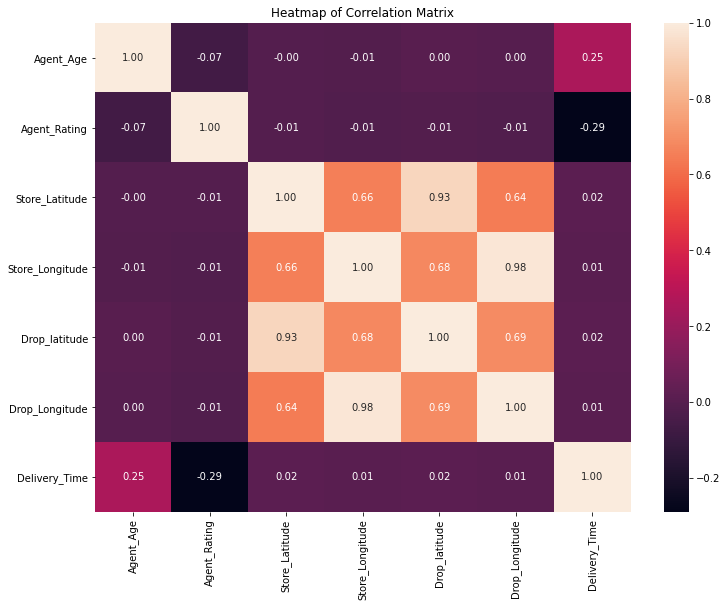

In [39]:
# Computing correlation matrix for selected features
features = numeric_features
correlation_matrix = {}

# Calculate the correlation between each pair of features
for feature1 in features:
    correlation_matrix[feature1] = {}
    for feature2 in features:
        correlation_value = amazon_delivery_data.stat.corr(feature1, feature2)
        correlation_matrix[feature1][feature2] = correlation_value

corr_df = pd.DataFrame(correlation_matrix)

# Plot the correlation matrix 
plt.figure(figsize=(12,9))
sns.heatmap(corr_df, annot=True, fmt=".2f")
plt.title('Heatmap of Correlation Matrix')
plt.show()

The above correlation heatmap shows both the magnitude and direction of the correlation between all the selected features of sales dataset.To interpret this heatmap, the correlation coeffient ranges from -1 to 1, if the coeffcient is positive, then the pair of attributes are positively related, if the coefficient is negtive, then the pair of attributes are negatively related.

We can see, the Store Longitude and Drop Longitude have very strong positive relationships(0.98). The Store Latitude and Drop Latitude are also related very positvely with a 0.93 correlation. The Store Longitude and Drop Latitude has a 0.68 positive correlation which is very strong too. Overall, these four features including Store Latitude, Store Longitude, Drop Latitude, Drop Longitude are closely related, intercted and influenced with each other. So, we are going to do further search on them.

### 3.2.3 Pair plot for selected features

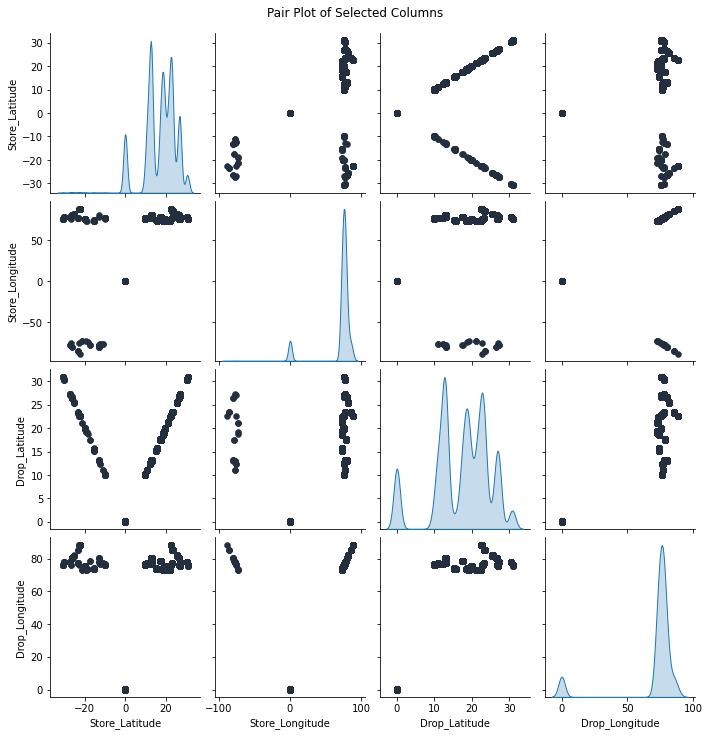

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the PySpark DataFrame to a Pandas DataFrame
# Select the required columns and convert to Pandas
pandas_df = amazon_delivery_data.select('Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude').toPandas()

# Set the color for the plots
color = '#232f3e'

# Create the pair plot for the selected columns
pair_plot = sns.pairplot(pandas_df, diag_kind='kde')

# Customize the plot appearance
for ax in pair_plot.axes.flatten():
    if ax:
        for artist in ax.lines + ax.collections:
            artist.set_color(color)
        for artist in ax.patches:
            artist.set_edgecolor(color)
            artist.set_facecolor(color)
    if hasattr(ax, 'collections'):
        for artist in ax.collections:
            artist.set_edgecolor(color)

# Add a title and display the plot
plt.suptitle('Pair Plot of Selected Columns', y=1.02)
plt.show()


## 3.3 Model Training

### 3.3.1 Training regression model using Linear Regression

In [41]:
from pyspark.ml.regression import LinearRegression

# Drop 'vector_features' if it already exists to avoid conflict
amazon_delivery_data = amazon_delivery_data.drop('vector_features')
amazon_delivery_data.printSchema()
# Apply VectorAssembler for feature processing with a new output column name
assembler = VectorAssembler(inputCols=numeric_features, outputCol='vector_features')
amazon_delivery_data = assembler.transform(amazon_delivery_data)

# Apply StandardScaler for data standardization
scaler = StandardScaler(inputCol='vector_features', outputCol='standardized_features', withStd=True, withMean=False)
scaler_model = scaler.fit(amazon_delivery_data)
scaled_data = scaler_model.transform(amazon_delivery_data)

# Split the data into training and test sets
train_data, test_data = scaled_data.randomSplit([0.8, 0.2])

# Train the Linear Regression model with the correct label column name
lr = LinearRegression(featuresCol='standardized_features', labelCol='Store_Latitude', maxIter=200)
lr_model = lr.fit(train_data)

# Show some predictions on the test data
predictions = lr_model.transform(test_data)
predictions.select('vector_features', 'Drop_Latitude', 'prediction').show(30)

root
 |-- Agent_Age: double (nullable = true)
 |-- Agent_Rating: double (nullable = true)
 |-- Store_Latitude: double (nullable = true)
 |-- Store_Longitude: double (nullable = true)
 |-- Drop_latitude: double (nullable = true)
 |-- Drop_Longitude: double (nullable = true)
 |-- Delivery_Time: double (nullable = true)
: string (nullable = true)

+--------------------+-------------+--------------------+
|     vector_features|Drop_Latitude|          prediction|
+--------------------+-------------+--------------------+
|[15.0,1.0,-23.351...|    23.421058| -23.351058000022338|
|[15.0,1.0,-17.426...|    17.486228|  -17.42622799999896|
|[15.0,1.0,-13.091...|    13.111809|   -13.0918089997663|
|[15.0,1.0,-13.049...|    13.129645| -13.049645000008077|
|[15.0,1.0,0.0,0.0...|         0.07|2.422082165592742...|
|[15.0,1.0,0.0,0.0...|         0.07|2.341040984685451...|
|[15.0,1.0,11.0036...|    11.133681|  11.003681000223967|
|[15.0,1.0,11.0250...|    11.085083|  11.025083000222159|
|[15.0,1.0,12.3

# 3.4 Model Evaluation

### 3.4.1 Residuals and RMSE

In [42]:
training_summary = lr_model.summary
training_summary.residuals.show()

+--------------------+
|           residuals|
+--------------------+
|-2.65256261400281...|
|-2.67661448560829...|
|-2.50313547667246...|
|-1.80158110651973...|
|1.788791337276052...|
|-4.17443857259058...|
|-2.38467854363553...|
|-2.27823093723600...|
|-2.27492691351471...|
|-2.18740581203746...|
|-2.25659491093210...|
|-2.28776997346358...|
|-2.26279439630161...|
|-2.22575735620011...|
|-2.23115748099189...|
|-2.18687290498564...|
|-2.29267271834032...|
|-2.18506102100946...|
|-2.30880203844208...|
|-2.24940066573253...|
+--------------------+
only showing top 20 rows



In [43]:
print("RMSE: {:.16f}".format(training_summary.rootMeanSquaredError))

RMSE: 0.0000000000209787


In [44]:
spark_regression.stop()

### 3.4.2 Limits of the model

This linear regression model might be underfitting in some regions, we can still see some areas where blue dots are far from the plane.  To get further improvement, we can add more features to train the data. We can also try other models like polynomial regression.

# 4. Recommendation using Collaborative Filtering

## 4.1 Data preparation

### 4.1.0 Import necessary libraries

In [45]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, NumericType
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

### 4.1.1 Load file amazon_electronics.csv from HDFS

In [46]:
electronics_HDFS = "hdfs://namenode:9000/amazon_electronics.csv"
electronics_local = "amazon_electronics.csv"

In [47]:
# Initialize a Sparksession 
spark_CF = SparkSession.builder.appName("Collaborative Filtering").config("spark.port.maxRetries", "50").getOrCreate()

# Read CSV file from HDFS 
amazon_electronics_data = spark_CF.read.option("multiLine", "true").option("header", "true").csv(electronics_local)

In [48]:
amazon_electronics_data.printSchema()

root
 |-- AKM1MP6P0OYPR: string (nullable = true)
 |-- 0132793040: string (nullable = true)
 |-- 5.0: string (nullable = true)
 |-- 1365811200: string (nullable = true)



- There is no titles for each column, so we rename each column. 

In [49]:
# Assuming the original columns are "userId", "productId", "Rating", "timestamp"
amazon_electronics_data = amazon_electronics_data \
    .withColumnRenamed("AKM1MP6P0OYPR", "user_id") \
    .withColumnRenamed("0132793040", "product_id") \
    .withColumnRenamed("5.0", "rating") \
    .withColumnRenamed("1365811200", "timestamp")

In [50]:
amazon_electronics_data.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



- Convert the all the string type to numeric

In [51]:
user_indexer = StringIndexer(inputCol = 'user_id', outputCol = 'user_id_index')
product_indexer = StringIndexer(inputCol = 'product_id', outputCol = 'product_id_index')
user_indexer.setHandleInvalid("error")
product_indexer.setHandleInvalid("error")
amazon_electronics_data = user_indexer.fit(amazon_electronics_data).transform(amazon_electronics_data)
amazon_electronics_data = product_indexer.fit(amazon_electronics_data).transform(amazon_electronics_data)

In [52]:
amazon_electronics_data = amazon_electronics_data.drop('user_id','product_id','timestamp')

In [53]:
from pyspark.sql.functions import col

# Cast 'user_id_index' and 'product_id_index' to int
amazon_electronics_data = amazon_electronics_data \
    .withColumn("rating", col("rating").cast("int")) \
    .withColumn("user_id_index", col("user_id_index").cast("int")) \
    .withColumn("product_id_index", col("product_id_index").cast("int")) \

# Show the cleaned data
amazon_electronics_data.show()


+------+-------------+----------------+
|rating|user_id_index|product_id_index|
+------+-------------+----------------+
|     4|        62976|            7850|
|     5|       171439|           15350|
|     4|        32356|           35352|
|     5|        57857|           16483|
|     5|        10743|           52676|
|     4|       142639|           10803|
|     5|       171232|             838|
|     5|        55309|           38548|
|     5|         7926|           38021|
|     5|        71539|             444|
|     5|        59156|             232|
|     5|         4510|           12723|
|     5|        96457|             669|
|     2|       153013|             769|
|     5|        11065|              45|
|     5|        37502|           61120|
|     5|        22689|           65208|
|     5|        45783|            2060|
|     4|       158495|            1354|
|     3|        12850|           32538|
+------+-------------+----------------+
only showing top 20 rows



In [54]:
amazon_electronics_data.printSchema()

root
 |-- rating: integer (nullable = true)
 |-- user_id_index: integer (nullable = true)
 |-- product_id_index: integer (nullable = true)



### 4.1.2 Check missing values

In [55]:
null_count_columns = []

for column in amazon_electronics_data.columns:
    # Count the number of null
    null_count = sum(col(column).isNull().cast("int")).alias(column)
    null_count_columns.append(null_count)

# Print results
amazon_electronics_data.select(null_count_columns).show()

+------+-------------+----------------+
|rating|user_id_index|product_id_index|
+------+-------------+----------------+
|     0|            0|               0|
+------+-------------+----------------+



## 4.2 Exploratory Data Analysis

- General information about dataset

In [56]:
amazon_electronics_data.describe().show()

+-------+------------------+-----------------+------------------+
|summary|            rating|    user_id_index|  product_id_index|
+-------+------------------+-----------------+------------------+
|  count|            187787|           187787|            187787|
|   mean| 4.018318626955008| 85163.0657500253| 17159.36625538509|
| stddev|1.3788946253427925|53616.06293028753|20583.034363454935|
|    min|                 1|                0|                 0|
|    max|                 5|           178683|             72526|
+-------+------------------+-----------------+------------------+



### 4.2.1 Distribution of 'rating'

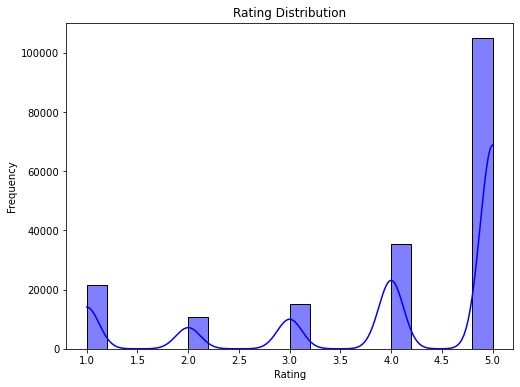

In [57]:
# Convert the Rating column to Pandas DataFrame
rating_pd = amazon_electronics_data.select("Rating").toPandas()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(rating_pd['Rating'], bins=20, kde=True, color='blue')

# Add title and labels
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [58]:
# Get unique counts for each column
unique_ratings = amazon_electronics_data.select("rating").distinct().count()
unique_user_ids = amazon_electronics_data.select("user_id_index").distinct().count()
unique_product_ids = amazon_electronics_data.select("product_id_index").distinct().count()

# Display the counts
print(f"Unique Ratings: {unique_ratings}")
print(f"Unique User IDs: {unique_user_ids}")
print(f"Unique Product IDs: {unique_product_ids}")


Unique Ratings: 5
Unique User IDs: 178684
Unique Product IDs: 72527


# 4.3 Model Training

### 4.3.1 Using Alternating Least Squares (ALS) algorithm for collaborative filtering

In [59]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

(training, test) = amazon_electronics_data.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
als = ALS(maxIter=20, regParam=0.01,rank=30, userCol="user_id_index", itemCol="product_id_index", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(training)
print(training.count())
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("RMSE = " + str(rmse))

150344
RMSE = 4.472612998642152


### 4.3.2 Limits of the model and thinking about unsatisfactory outcomes

We can see the RMSE is above 4, that means the training model is not fit well with the given dataset. Here is my thinking: The most important reason is that the dataset is not large enough. What do I mean? Although the dataset seems very large, with 187787 rows, the dataset is still too small. Actually, I have truncated the dataset and the previous whole set has even more than 4 million records! So, what actually caused the loss of information? 

The first reason is the sparsity of the user-item interaction matrix. ALS requires a user-item interaction matrix, so the 180,000 records we extracted may be too sparse, meaning there are too few interactions between users and items, making it difficult for the model to learn useful patterns.

The second reason is the lack of representative data. The data we extracted may not well represent the distribution of the original dataset. If certain users or items appear less frequently in the subset, but they are common in the full dataset, the model might struggle to generalize properly.

The third reason is the Hyperparameter settings.ALS relies on many hyperparameters including 'maxIter', 'regParam', 'implicitPrefs', 'rank'. If these are not set properly, it can lead to poor model performance.

<div style="border: 10px double #FFC0CB; padding: 15px; border-radius: 20px;">
    <h3 style="text-align: center; color: #FFC0CB;">END OF THE PROJECT   THANK YOU FOR READING</h3>
</div>
